# PRÁCTICA FINAL.



# Análisis exploratorio: PCA y clustering

En este notebook realizaremos un análisis de componentes principales (PCA) y clustering sobre dos conjuntos de datos públicos, con el fin de reducir dimensionalidad, explorar estructura interna y agrupar observaciones similares.  

## 📦 Datasets usados

- **Calidad de vino** — proviene del repositorio en línea de Kaggle: *brendan45774/wine-quality*. Contiene mediciones fisicoquímicas de distintas muestras de vino, así como una puntuación de la calidad del vino. :contentReference[oaicite:1]{index=1}  
  - Enlace: https://www.kaggle.com/datasets/brendan45774/wine-quality

- **Compradores centro comercial** — también obtenido desde Kaggle: *wasiqaliyasir/simple‑mall‑customers‑dataset*. Este dataset contiene información demográfica y de comportamiento (edad, ingreso anual, puntuación de gasto, etc.) de clientes, ideal para segmentación mediante clustering. :contentReference[oaicite:2]{index=2}  
  - Enlace: https://www.kaggle.com/datasets/wasiqaliyasir/simple-mall-customers-dataset


## Prepración de liberías

In [1]:
# Importar librerías
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

plt.style.use("ggplot")

%matplotlib inline
print("Librerías cargadas.")

Librerías cargadas.


## Carga de datos de calidad de vino

In [2]:
# Cargar los datasets
red_path = 'winequality-red.csv'
white_path = 'winequality-white.csv'

dfs = {}
for label, path in [('red', red_path), ('white', white_path)]:
    if os.path.exists(path):
        dfs[label] = pd.read_csv(path, sep=';')
        print(f"Cargado {path}: {dfs[label].shape}")
    else:
        print(f"Archivo no encontrado: {path}")

# Combinar si ambos existen
if 'red' in dfs and 'white' in dfs:
    red = dfs['red'].copy()
    white = dfs['white'].copy()
    red['type'] = 'red'
    white['type'] = 'white'
    df = pd.concat([red, white], ignore_index=True)
    print("\nDataset combinado:", df.shape)

elif 'red' in dfs:
    df = dfs['red'].copy()
    df['type'] = 'red'
    print("\nUsando solo dataset rojo.")

elif 'white' in dfs:
    df = dfs['white'].copy()
    df['type'] = 'white'
    print("\nUsando solo dataset blanco.")

else:
    raise FileNotFoundError("No se encontraron los CSV.")

df.head()

Cargado winequality-red.csv: (1599, 12)
Cargado winequality-white.csv: (4898, 12)

Dataset combinado: (6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


# Visualización de datos

In [3]:
print('Dimensiones:', df.shape)
print("\nColumnas:", df.columns.tolist())

print("\nInfo:")
display(df.info())

print("\nDescripción estadística:")
display(df.describe())

Dimensiones: (6497, 13)

Columnas: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'type']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float

None


Descripción estadística:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


## Comprobación de datos no válidos en el dataset


In [4]:
print("Valores nulos por columna:")
print(df.isnull().sum())

print("\nDuplicados:", df.duplicated().sum())

Valores nulos por columna:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

Duplicados: 1177


## Distribuciones y correlaciones

La distribución de calidad está claramente concentrada en las clases 5 y 6, con muy pocos ejemplos en los extremos (3, 4, 8, 9). Esto indica un desbalance del objetivo: los modelos tenderán a aprender bien el rango medio y peor los valores raros. En clasificación conviene estratificar el muestreo o ponderar clases; en regresión, comparar el rendimiento frente a un baseline que prediga el valor medio.

En el pairplot, se observan patrones coherentes con la química del vino: el alcohol tiende a ser mayor en vinos de calidad alta, mientras que la acidez volátil se asocia a calidades bajas. Variables como residual sugar muestran distribuciones muy sesgadas y relaciones no lineales con la calidad. Hay solapamiento entre clases en casi todos los pares de variables, por lo que el clustering no separará perfectamente sin reducción de dimensión y buen escalado.

La matriz de correlación confirma las relaciones principales: alcohol y sulphates correlacionan positivamente con calidad, y volatile acidity y density lo hacen negativamente. Se aprecia multicolinealidad (p. ej., fuerte correlación entre free y total sulfur dioxide, y entre density y residual sugar), lo que hace recomendable aplicar PCA para compactar información y usar regresión regularizada (Ridge/Lasso) para mitigar redundancias.

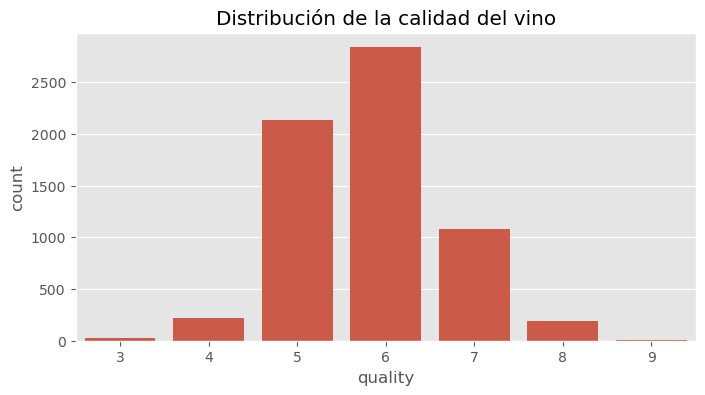

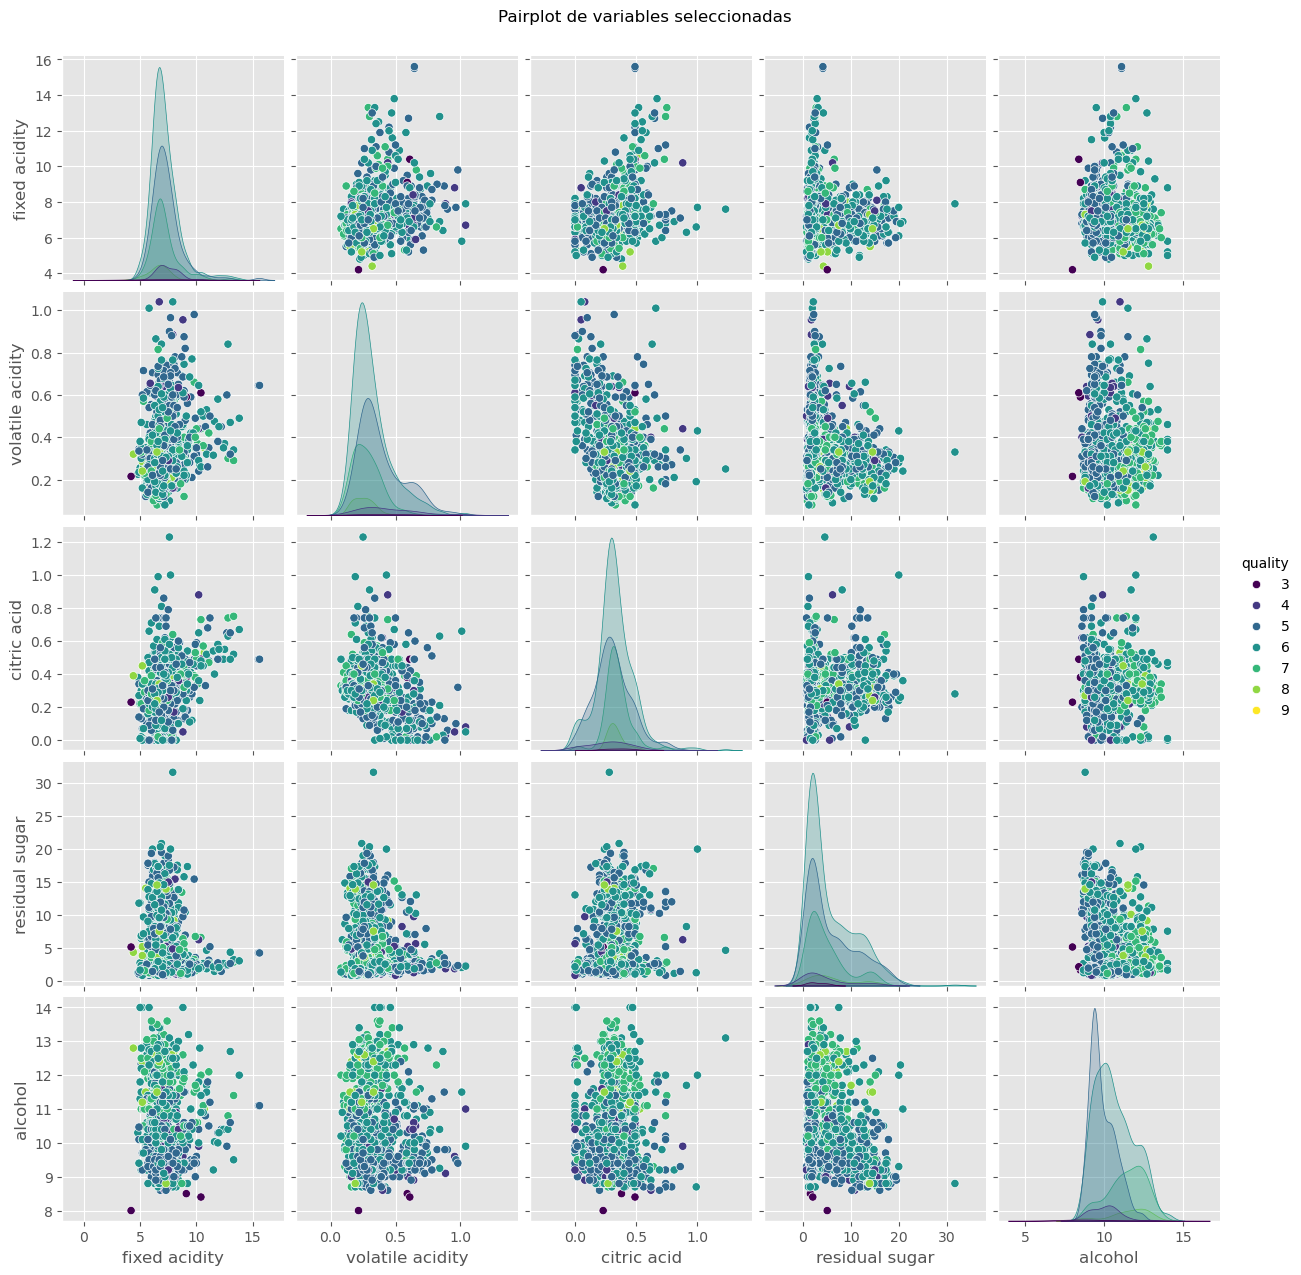

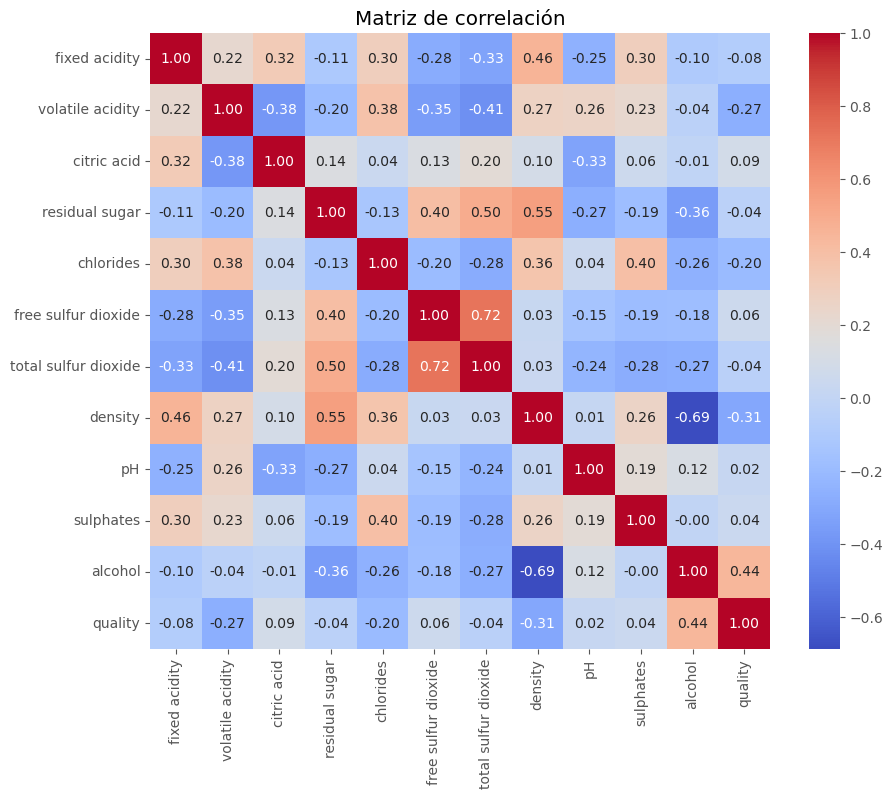

In [5]:
# Histograma de quality
plt.figure(figsize=(8,4))
sns.countplot(x='quality', data=df)
plt.title("Distribución de la calidad del vino")
plt.show()

# Pairplot con submuestra
cols_sample = ['fixed acidity', 'volatile acidity', 'citric acid',
               'residual sugar', 'alcohol', 'quality']

sns.pairplot(df[cols_sample].sample(n=1000, random_state=0),
             hue='quality', palette='viridis')
plt.suptitle("Pairplot de variables seleccionadas", y=1.02)
plt.show()

# Matriz de correlaciones
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

## Preparación para PCA
Se seleccionan las variables numéricas (excepto `quality`) y se estandarizan.

In [6]:
features = df.select_dtypes(include=[np.number]).columns.tolist()

# Quitamos quality para no mezclar objetivo con features del PCA
if 'quality' in features:
    features.remove('quality')

X = df[features].values
y = df['quality'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape X_scaled:", X_scaled.shape)

Shape X_scaled: (6497, 11)


El análisis PCA revela dos aspectos clave. Primero, la gráfica de varianza muestra que las primeras componentes concentran la mayor información: la primera explica cerca del 25%, la segunda un 20%, y con 4 a 6 componentes se alcanza entre el 70% y el 85% de la varianza acumulada. Esto indica que es posible reducir la dimensionalidad manteniendo la mayoría de la información relevante.

Segundo, la proyección en las dos primeras componentes (PC1 y PC2) permite visualizar la estructura global del dataset, pero no separa claramente las clases de calidad. Aunque se observa cierta tendencia —los vinos de mayor calidad tienden a agruparse hacia la derecha— los colores están mezclados, lo que confirma que la relación entre variables y calidad es compleja y no lineal.

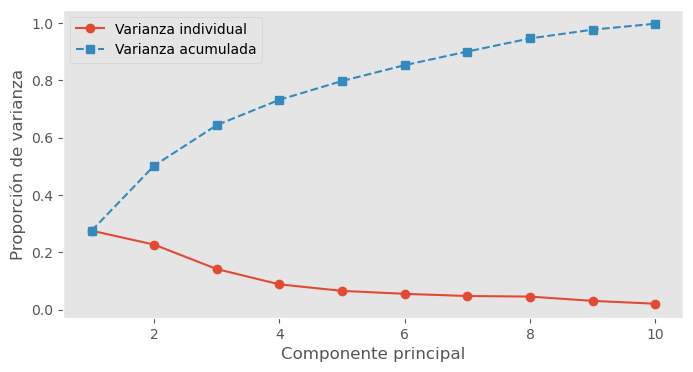

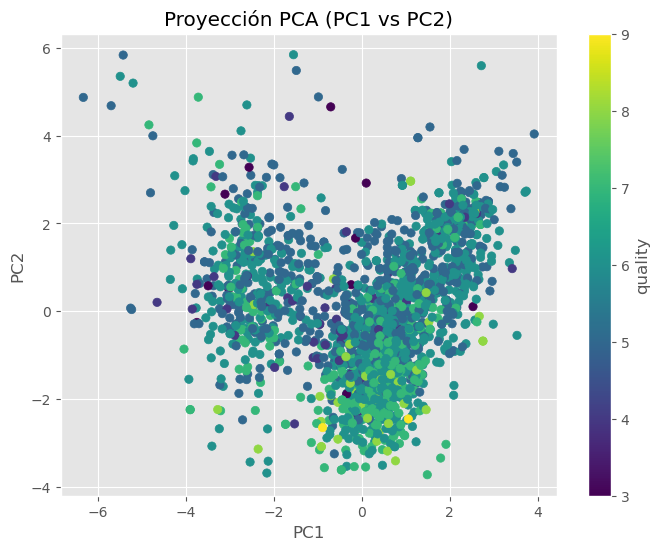

In [7]:
# PCA
pca = PCA(n_components=min(10, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)

exp = pca.explained_variance_ratio_
cumexp = exp.cumsum()

plt.figure(figsize=(8,4))
plt.plot(range(1, len(exp)+1), exp, 'o-', label="Varianza individual")
plt.plot(range(1, len(exp)+1), cumexp, 's--', label="Varianza acumulada")
plt.xlabel("Componente principal")
plt.ylabel("Proporción de varianza")
plt.grid()
plt.legend()
plt.show()

# Scatter PC1 vs PC2
idx = np.random.choice(len(X_pca), size=min(2000, len(X_pca)), replace=False)
plt.figure(figsize=(8,6))
sc = plt.scatter(X_pca[idx,0], X_pca[idx,1], c=y[idx], cmap='viridis')
plt.colorbar(sc, label='quality')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Proyección PCA (PC1 vs PC2)")
plt.show()

## Clasificación: ¿podemos predecir la calidad?
Se crea una clasificación en 3 categorías (baja, media, alta) y se compara:
- RandomForest con features originales
- RandomForest con las primeras 5 componentes principales

In [8]:
# Convertir quality en categorías
y_cat = pd.cut(df['quality'], bins=[-1,5,6,10],
               labels=['low','medium','high'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_cat, test_size=0.25, random_state=0, stratify=y_cat)

# RandomForest original
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("RandomForest con features originales")
print(classification_report(y_test, y_pred))
display(pd.DataFrame(confusion_matrix(y_test, y_pred),
                     index=rf.classes_, columns=rf.classes_))

# Con 5 componentes
pca5 = PCA(n_components=5)
Xpca = pca5.fit_transform(X_scaled)

Xp_tr, Xp_te, yp_tr, yp_te = train_test_split(
    Xpca, y_cat, test_size=0.25, random_state=0, stratify=y_cat)

rf2 = RandomForestClassifier(n_estimators=100, random_state=0)
rf2.fit(Xp_tr, yp_tr)
y_pred2 = rf2.predict(Xp_te)

print("\nRandomForest con 5 componentes principales")
print(classification_report(yp_te, y_pred2))


RandomForest con features originales
              precision    recall  f1-score   support

        high       0.72      0.57      0.64       320
         low       0.78      0.73      0.75       596
      medium       0.65      0.75      0.70       709

    accuracy                           0.71      1625
   macro avg       0.72      0.68      0.70      1625
weighted avg       0.71      0.71      0.71      1625



,high,low,medium
high,182,8,130
low,7,436,153
medium,63,117,529



RandomForest con 5 componentes principales
              precision    recall  f1-score   support

        high       0.70      0.59      0.64       320
         low       0.74      0.72      0.73       596
      medium       0.65      0.71      0.68       709

    accuracy                           0.69      1625
   macro avg       0.70      0.67      0.68      1625
weighted avg       0.69      0.69      0.69      1625



## Conclusiones

- Existe una correlación clara entre varias variables físico-químicas y la calidad del vino.
- El PCA reduce bien la dimensionalidad aunque se requiere un número moderado de componentes para explicar la varianza.
- El RandomForest predice la calidad con accuracy razonable, pero las clases están desequilibradas.
- Las componentes principales permiten entrenar con menos variables y rendimiento similar

# DATOS DE COMPRADORES CENTRO COMERCIAL

Carga de datos

In [9]:
df = pd.read_csv("Mall_Customers.csv")  # ajusta nombre si es distinto
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Lectura de información de datos


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [11]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [12]:
print("Valores nulos por columna:\n", df.isna().sum())
print("Duplicados:", df.duplicated().sum())

Valores nulos por columna:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
Duplicados: 0


In [13]:
# Drop CustomerID (no aporta para clustering)
df_proc = df.drop("CustomerID", axis=1)

# Si Gender está como string, codificamos (opcional — depende si lo usas)
df_proc = pd.get_dummies(df_proc, columns=["Gender"], drop_first=True)

df_proc.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,19,15,39,True
1,21,15,81,True
2,20,16,6,False
3,23,16,77,False
4,31,17,40,False


## Estandarización


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_proc)
print("Shape:", X_scaled.shape)

Shape: (200, 4)


El gráfico muestra la varianza explicada acumulada por las componentes principales en el PCA. Con una sola componente se explica alrededor del 35% de la varianza, con dos componentes cerca del 60%, y con tres se supera el 80%, alcanzando el 100% al incluir la cuarta. Esto indica que 3 o 4 componentes son suficientes para conservar la mayor parte de la información del dataset, logrando una reducción de dimensionalidad efectiva sin perder variabilidad significativa.

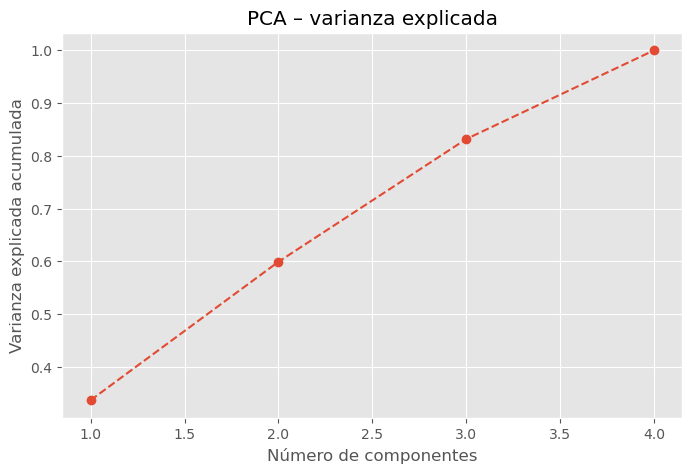

In [15]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained)+1), cum_explained, marker="o", linestyle="--")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA – varianza explicada")
plt.grid(True)
plt.show()

Este biplot PCA muestra cómo las dos primeras componentes principales resumen la información del dataset y la influencia de cada variable. PC1 está dominada por la oposición entre Age y Spending Score, mientras que PC2 refleja principalmente el efecto de Annual Income y, en menor medida, Gender_Male. La longitud y dirección de las flechas indican que Annual Income y Age son las variables más influyentes en la estructura, mientras que Spending Score actúa en sentido contrario a la edad. En conjunto, el gráfico evidencia que las primeras dos componentes capturan patrones relacionados con edad, gasto e ingresos, útiles para segmentación y análisis exploratorio.

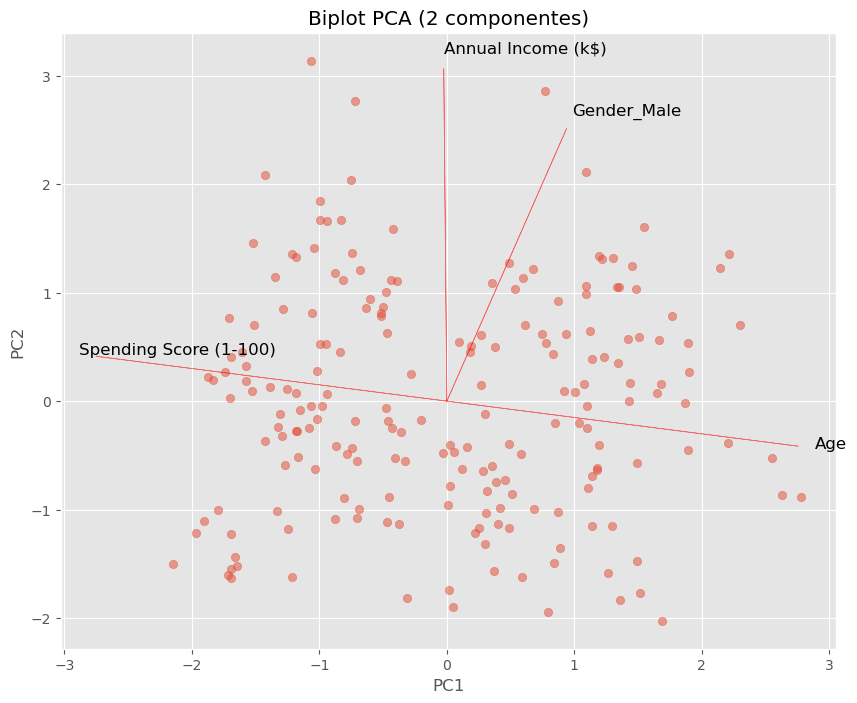

In [16]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_pca2[:,0], X_pca2[:,1], alpha=0.5)

# Dibujar vectores de variables para biplot
variables = df_proc.columns
for i, v in enumerate(variables):
    plt.arrow(0, 0,
              pca2.components_[0, i]*4,
              pca2.components_[1, i]*4,
              color='r', alpha=0.5)
    plt.text(pca2.components_[0, i]*4.2,
             pca2.components_[1, i]*4.2,
             v, color='black', fontsize=12)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Biplot PCA (2 componentes)")
plt.grid(True)
plt.show()

El gráfico muestra cómo la inercia disminuye al aumentar el número de clusters en K-Means. La caída es pronunciada entre k=2 y k=5, y a partir de k=6 la mejora se vuelve marginal, formando el “codo” en esa zona. Esto indica que el número óptimo de clusters para segmentar a los clientes está entre 5 y 6, logrando un buen equilibrio entre compacidad y simplicidad del modelo.
Proporcione sus comentarios sobre BizChat

c:\Users\Willy\miniforge3\envs\micro\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\Willy\miniforge3\envs\micro\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Willy\miniforge3\envs\micro\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL,

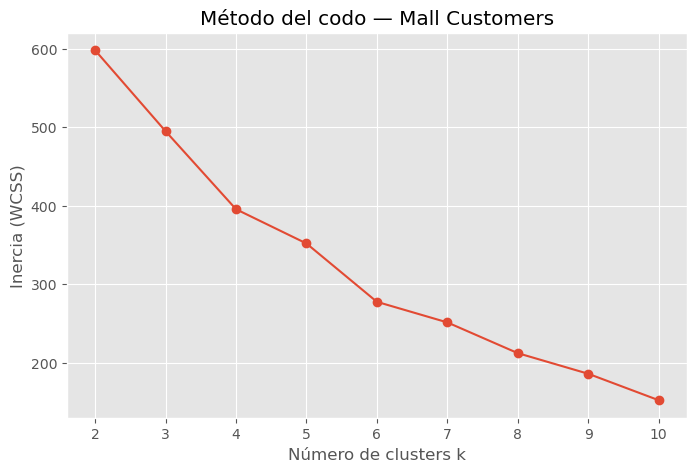

In [17]:
inertias = []
K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertias, marker='o')
plt.xlabel("Número de clusters k")
plt.ylabel("Inercia (WCSS)")
plt.title("Método del codo — Mall Customers")
plt.grid(True)
plt.show()

### Comentario previo a la celda 18
Esta celda realiza una operación o cálculo relacionado con la práctica.


c:\Users\Willy\miniforge3\envs\micro\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Willy\miniforge3\envs\micro\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Willy\miniforge3\envs\micro\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Willy\miniforge3\envs\micro\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

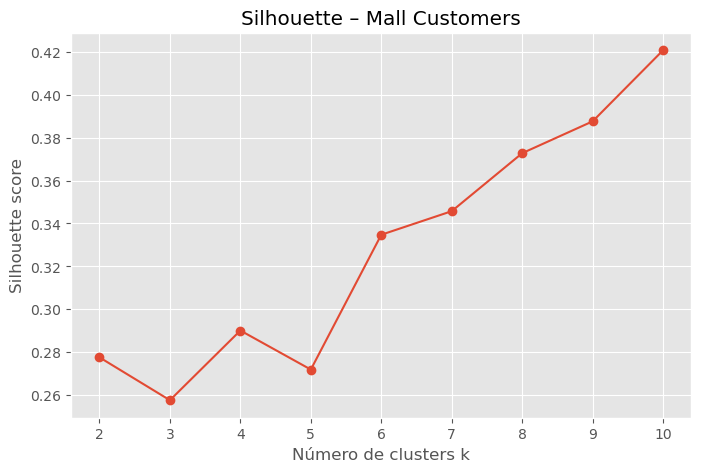

In [18]:
scores = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8,5))
plt.plot(K, scores, marker='o')
plt.xlabel("Número de clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette – Mall Customers")
plt.grid(True)
plt.show()

La calidad de la segmentación varía al cambiar el número de clusters en K-Means. El puntaje es bajo para valores pequeños de k (≈0.26–0.29 en 2 a 5 clusters) y mejora significativamente a partir de k=6, alcanzando su máximo en k=10 (≈0.42). Esto indica que más clusters generan mejor separación, aunque demasiados grupos pueden perder interpretabilidad. Un rango entre 6 y 8 clusters ofrece un buen equilibrio entre calidad y simplicidad.

In [25]:
k_final = 4  # puedes modificar según resultado del elbow / silhouette
kmeans = KMeans(n_clusters=k_final, random_state=42)
df["cluster_orig"] = kmeans.fit_predict(X_scaled)

df.groupby("cluster_orig").mean(numeric_only=True)

c:\Users\Willy\miniforge3\envs\micro\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,CustomerID,Age,Annual Income (k$),Spending Score (1-100),cluster_pca
cluster_orig,,,,,
0,67.783333,54.700000,46.900000,39.933333,0.583333
1,164.529412,41.264706,88.500000,16.764706,0.147059
2,100.809524,28.690476,60.904762,70.238095,2.547619
3,96.953125,29.375000,58.296875,64.437500,1.953125


Este gráfico muestra los clusters generados por K-Means proyectados en el espacio de las dos primeras componentes principales (PC1 y PC2) tras aplicar PCA. Se observan cuatro grupos bien definidos: el cluster azul (0) se concentra en la parte derecha, el naranja (1) en la zona inferior central, el verde (2) en la izquierda y el rojo (3) en la parte superior central.

La separación entre clusters es clara en PC1, que parece capturar diferencias importantes entre los grupos, mientras que PC2 aporta variabilidad adicional que ayuda a distinguir el cluster rojo del resto. Esta estructura indica que el PCA ha permitido reducir la dimensionalidad manteniendo una buena separación, y que el modelo K-Means ha segmentado a los clientes en grupos con patrones diferenciados, probablemente relacionados con variables como edad, ingresos y gasto.

c:\Users\Willy\miniforge3\envs\micro\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


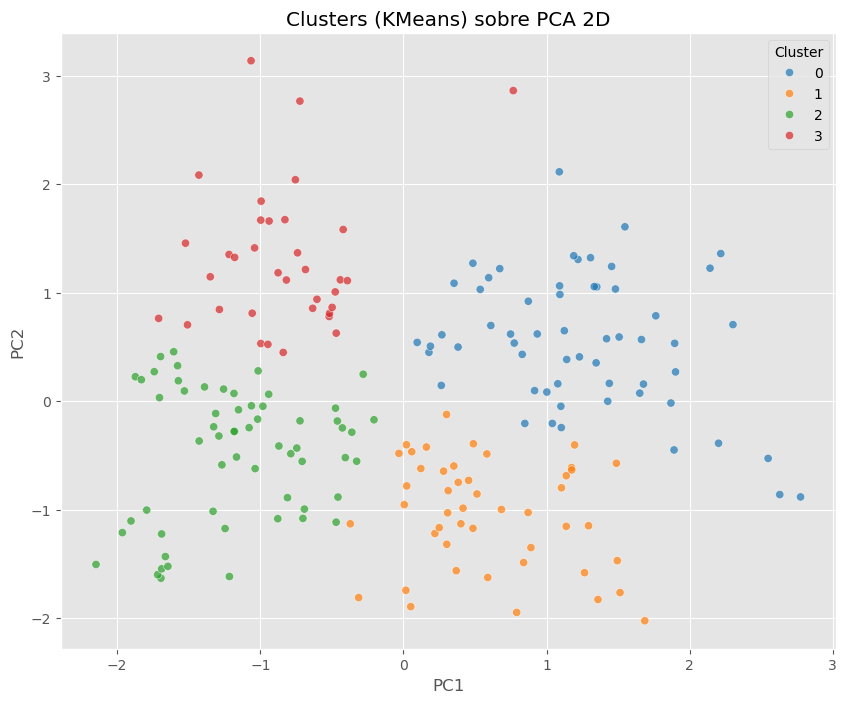

In [22]:
kmeans_pca = KMeans(n_clusters=k_final, random_state=42)
df["cluster_pca"] = kmeans_pca.fit_predict(X_pca2)

plt.figure(figsize=(10,8))
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1],
                hue=df["cluster_pca"],
                palette="tab10",
                alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters (KMeans) sobre PCA 2D")
plt.legend(title="Cluster")
plt.show()

In [ ]:
# Centroide de clusters (valores medios por cluster)
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                               columns=df_proc.columns)
cluster_centers

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,54.700000,46.900000,39.933333,4.333333e-01
1,41.264706,88.500000,16.764706,5.882353e-01
2,28.690476,60.904762,70.238095,1.000000e+00
3,29.375000,58.296875,64.437500,-4.440892e-16


In [ ]:
# Cuántos clientes hay por cluster
df["cluster_orig"].value_counts()

cluster_orig
3    64
0    60
2    42
1    34
Name: count, dtype: int64